# Initial Cleaning for Building0

In [148]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import copy
from scipy.signal import find_peaks
import scipy
import seaborn as sns

In [149]:
# Set Plot Styling
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [171]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [151]:
demand_df

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148805,2020-09-30 22:45:00,96.9,14.4,389.0,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
148806,2020-09-30 23:00:00,96.9,18.8,389.0,1.0,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
148807,2020-09-30 23:15:00,37.4,4.5,415.0,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62
148808,2020-09-30 23:30:00,37.4,9.6,415.0,NaN,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94


In [152]:
# Filling Missing Values Function
def fill_missing(df):
    arr = []
    for col in df.columns:
        df[col] = df[col].fillna(df.mean(axis=1))
        arr += list(df[col])
    return arr

number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35040
number of 15 min intervals in year 3: 35040
number of 15 min intervals in year 4: 35136


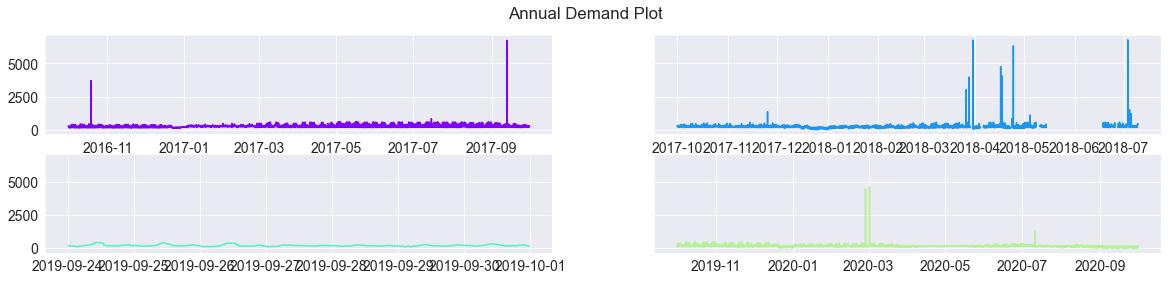

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
#create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2016', '2017', '2018', '2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building0'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building0'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building0'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2016-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building0'] = fill_missing(building_df)
demand_df.head()

In [155]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building0'], height=700)
Building0_peaks = np.zeros(len(demand_df))
Building0_peaks[:] = np.NaN
for i in peaks:
    Building0_peaks[i] = demand_df['Building0'][i]

# save smoothed demand_df
demand_df['Building0'] = smooth_like_butter(peaks, demand_df['Building0'])
demand_df.to_csv("demand_smoothed_building0")

# Autoregressive Forecasting Setup 

In [156]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  148810 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [157]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Building0"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -21.20862933758451
p-value: 0.0


As we have a very large, negative ADF statistic and an extremely low p-value of 0 - we can reject the null hypothesis and say that our time series is stationary.

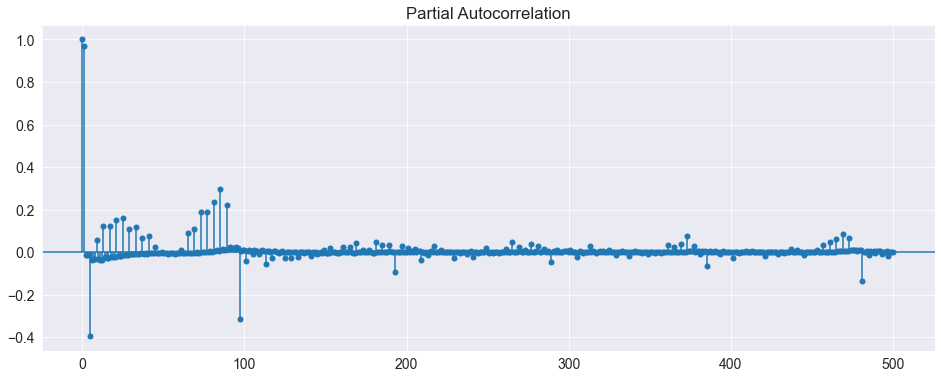

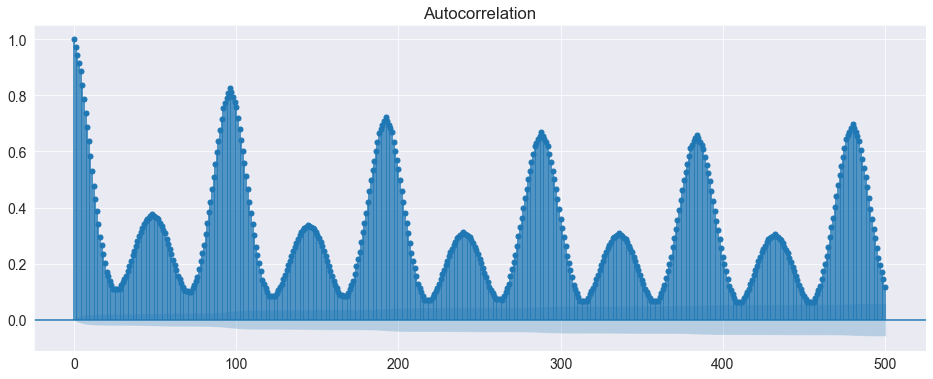

In [158]:
# Plot autocorrelation and partial autocorrelation plots
plot_pacf(demand_df["Building0"], lags=500);
plot_acf(demand_df["Building0"], lags=500);

For Partial Autocorrelation:
- Coefficient importance is very low as the number of lags increases, however you can see that at about ~100, the importance decreases dramatically onwards.

For Autocorrelation: 
- Coefficient importance acts in a wave-like fashion, so choosing the number of lags closer towards peaks will improve the forecast. The coefficient importance is slowly decreasing as the number of lag decrease.

# Autoregressive Forecasting For Building 0 

In [159]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [160]:
mod = AutoReg(demand_df["Building0"], 2000, old_names=False)
res = mod.fit()
print(res.summary())

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


                            AutoReg Model Results                             
Dep. Variable:              Building0   No. Observations:               148810
Model:                  AutoReg(2000)   Log Likelihood             -549318.353
Method:               Conditional MLE   S.D. of innovations             10.204
Date:                Sun, 17 Oct 2021   AIC                              4.673
Time:                        20:44:43   BIC                              4.808
Sample:                    07-24-2016   HQIC                             4.713
                         - 09-30-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2550      0.160      1.599      0.110      -0.058       0.568
Building0.L1        0.9780      0.003    374.726      0.000       0.973       0.983
Building0.L2        0.0021      

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


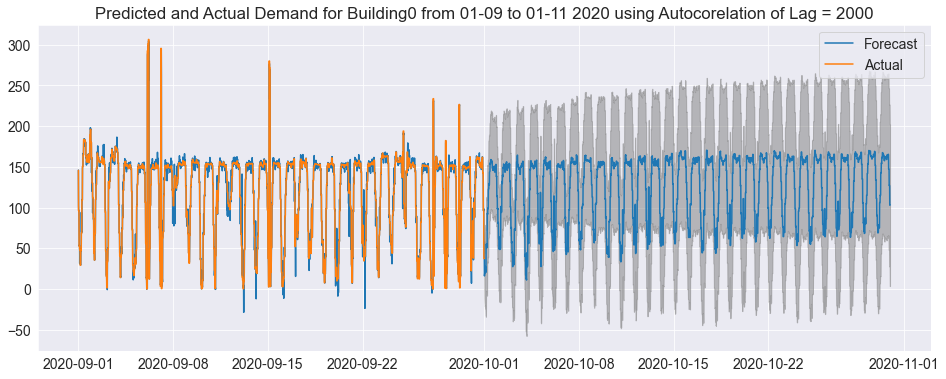

In [161]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2016-07-03 21:30:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Building0"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Demand for Building0 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Building 1

In [ ]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [109]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Building1"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Building1"])-1, 0, -1):
    if str(demand_df.at[i, "Building1"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2018-10-01 00:00:00 78634
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


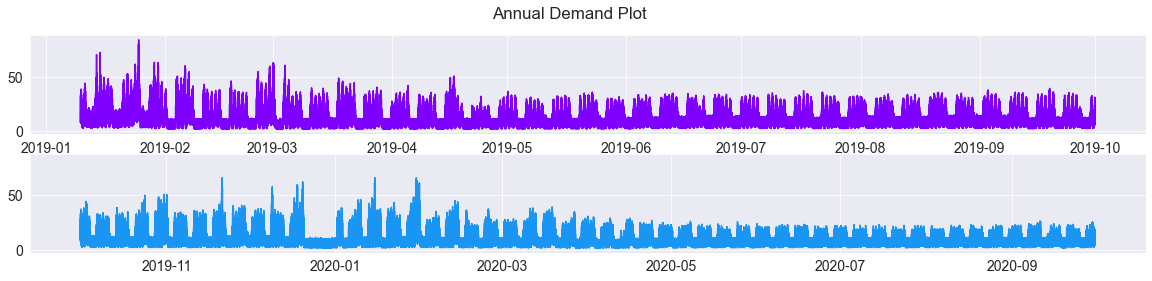

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building1'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building1'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building1'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building1'] = fill_missing(building_df)
demand_df.head()

In [166]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building1'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Building1'][i]

# save smoothed demand_df
demand_df['Building1'] = smooth_like_butter(peaks, demand_df['Building1'])
demand_df.to_csv("demand_smoothed_building1")

In [167]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  70172 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [133]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Building1"][78634:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.646461257463972
p-value: 1.6178914577924625e-29


In [168]:
mod = AutoReg(demand_df["Building1"][78634:148809].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


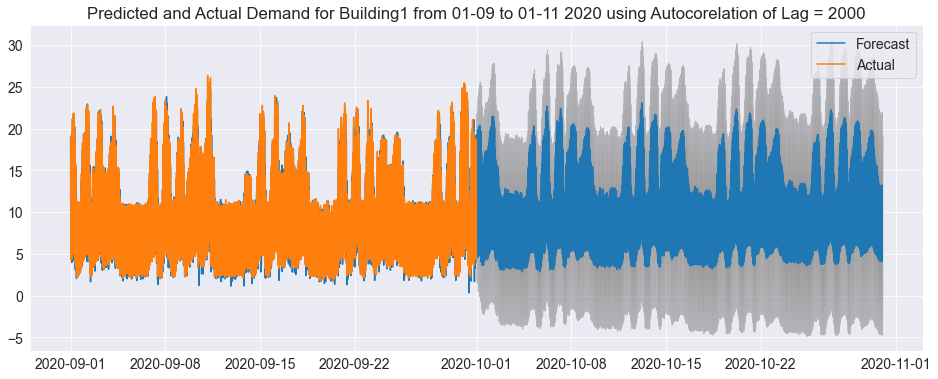

In [169]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Building1"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Demand for Building1 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Building 3

In [ ]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [172]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Building3"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Building3"])-1, 0, -1):
    if str(demand_df.at[i, "Building3"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2016-07-03 21:30:00 0
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35040
number of 15 min intervals in year 3: 35040
number of 15 min intervals in year 4: 35136


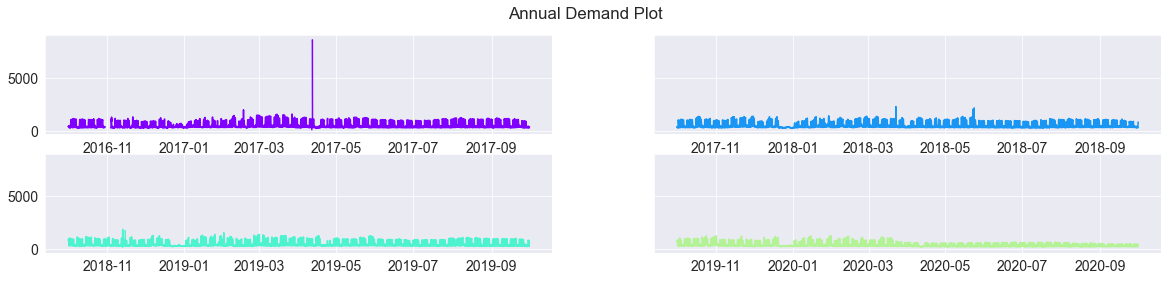

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
#create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2016', '2017', '2018','2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building3'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building3'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building3'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2016-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building3'] = fill_missing(building_df)
demand_df.head()

In [174]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building3'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Building3'][i]

# save smoothed demand_df
demand_df['Building3'] = smooth_like_butter(peaks, demand_df['Building3'])
demand_df.to_csv("demand_smoothed_building3")

In [175]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148809 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [178]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Building3"].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.473277376994325
p-value: 0.0


In [179]:
mod = AutoReg(demand_df["Building3"].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


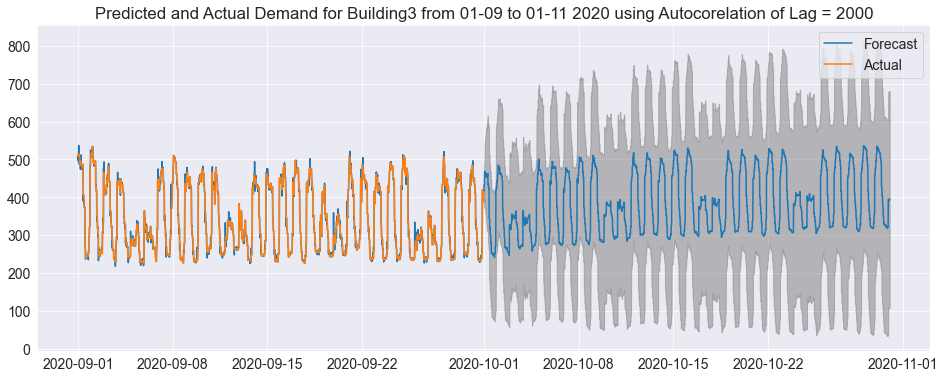

In [180]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Building3"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Demand for Building3 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Building 4

In [203]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [204]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Building4"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Building4"])-1, 0, -1):
    if str(demand_df.at[i, "Building4"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-07-03 04:45:00 105053
Last: 2020-09-30 23:00:00 148806


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


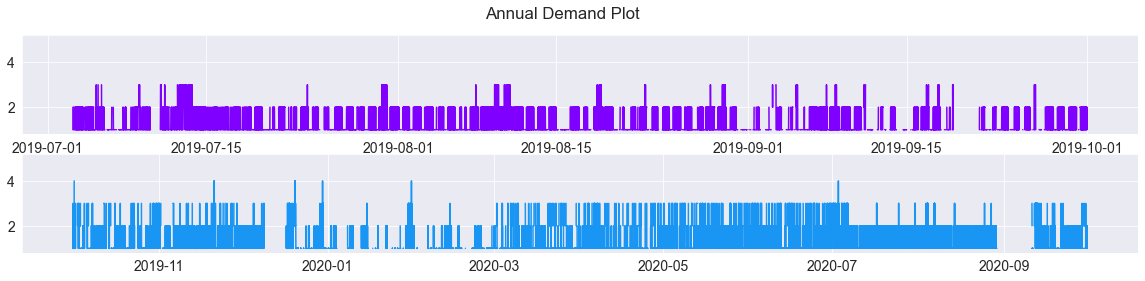

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building4'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building4'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building4'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building4'] = fill_missing(building_df)
demand_df.head()

In [206]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building4'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Building4'][i]

# save smoothed demand_df
demand_df['Building4'] = smooth_like_butter(peaks, demand_df['Building4'])
demand_df.to_csv("demand_smoothed_building4")

In [207]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  45593 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [208]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Building4"][105053:148806].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -18.127383968270287
p-value: 2.5116618841271925e-30


In [209]:
mod = AutoReg(demand_df["Building4"][105053:148806].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


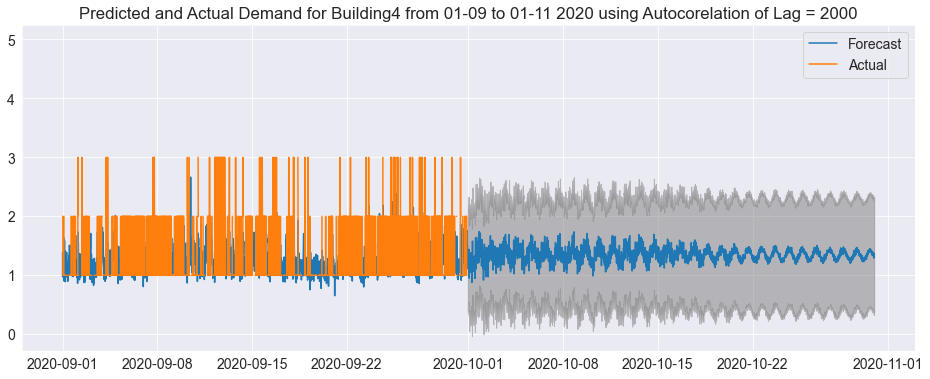

In [210]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Building4"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Demand for Building4 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Building 5

In [194]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [195]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Building5"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Building5"])-1, 0, -1):
    if str(demand_df.at[i, "Building5"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-07-25 23:00:00 107238
Last: 2020-09-30 05:15:00 148735


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


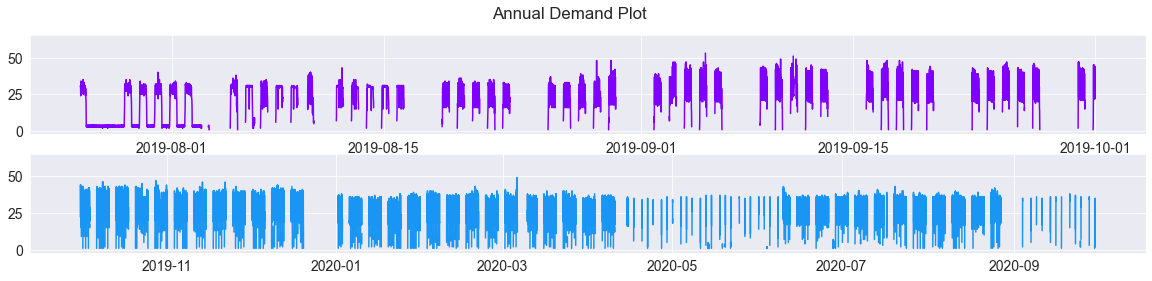

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building5'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building5'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building5'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building5'] = fill_missing(building_df)
demand_df.head()

In [198]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building5'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Building5'][i]

# save smoothed demand_df
demand_df['Building5'] = smooth_like_butter(peaks, demand_df['Building5'])
demand_df.to_csv("demand_smoothed_building5")

In [199]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  21250 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [200]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Building5"][107238:148735].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.237406110922574
p-value: 3.757577402776493e-29


In [201]:
mod = AutoReg(demand_df["Building5"][107238:148735].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


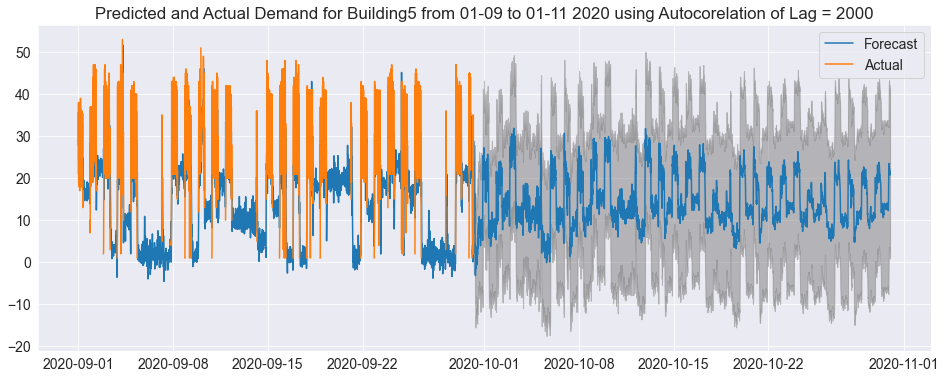

In [202]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Building5"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Demand for Building5 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Building 6

In [211]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [212]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Building6"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Building6"])-1, 0, -1):
    if str(demand_df.at[i, "Building6"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-07-25 01:45:00 107153
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


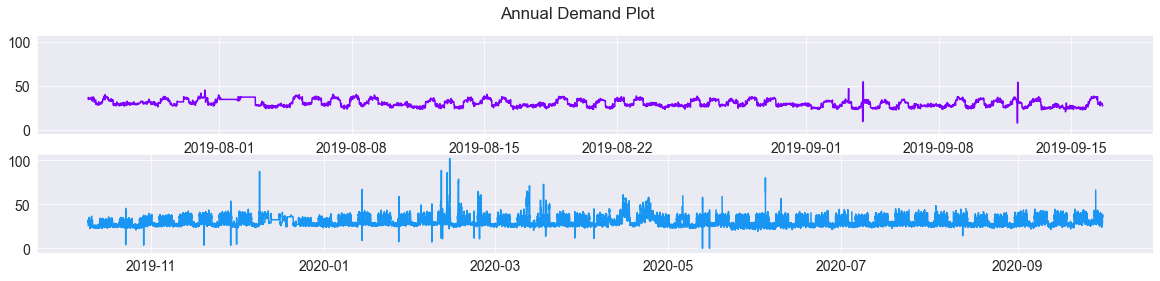

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building6'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building6'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building6'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building6'] = fill_missing(building_df)
demand_df.head()

In [214]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building6'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Building6'][i]

# save smoothed demand_df
demand_df['Building6'] = smooth_like_butter(peaks, demand_df['Building6'])
demand_df.to_csv("demand_smoothed_building6")

In [215]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  68440 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [216]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Building6"][107153:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.572277405109087
p-value: 1.8656612196730066e-29


In [217]:
mod = AutoReg(demand_df["Building6"][107153:148809].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


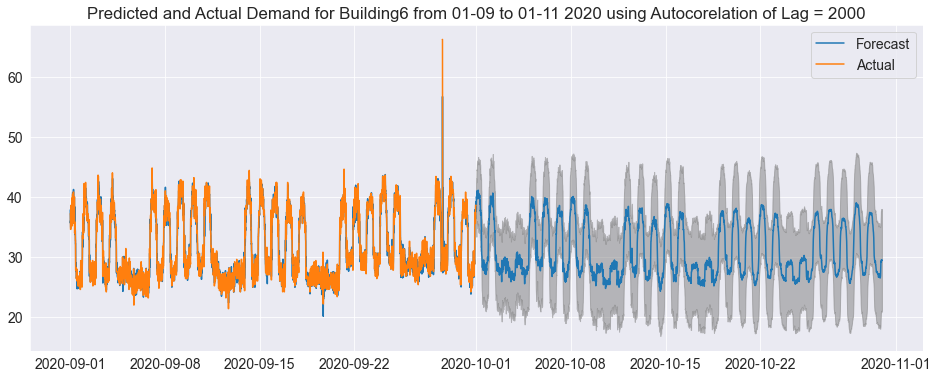

In [218]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Building6"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Demand for Building6 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Solar0

In [219]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [220]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Solar0"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Solar0"])-1, 0, -1):
    if str(demand_df.at[i, "Solar0"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2020-04-25 14:00:00 133602
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


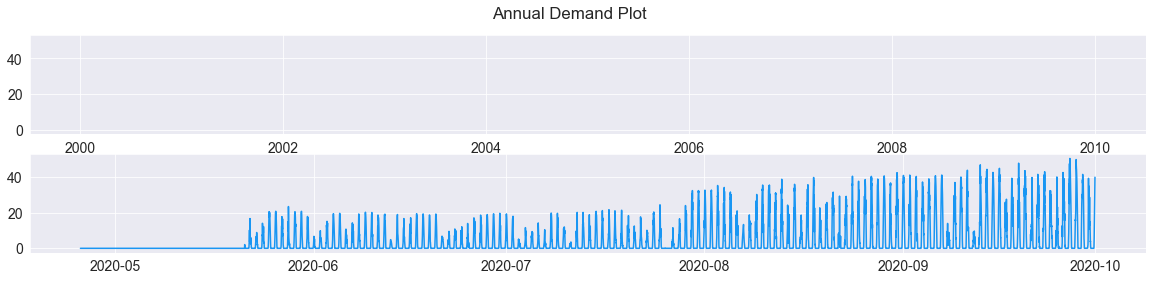

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019','2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Solar0'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Solar0'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Solar0'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Solar0'] = fill_missing(building_df)
demand_df.head()

In [226]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Solar0'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Solar0'][i]

# save smoothed demand_df
demand_df['Solar0'] = smooth_like_butter(peaks, demand_df['Solar0'])
demand_df.to_csv("demand_smoothed_solar0")

In [227]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     30320 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [228]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Solar0"][133602:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -20.34100322054499
p-value: 0.0


In [229]:
mod = AutoReg(demand_df["Solar0"][133602:148809].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


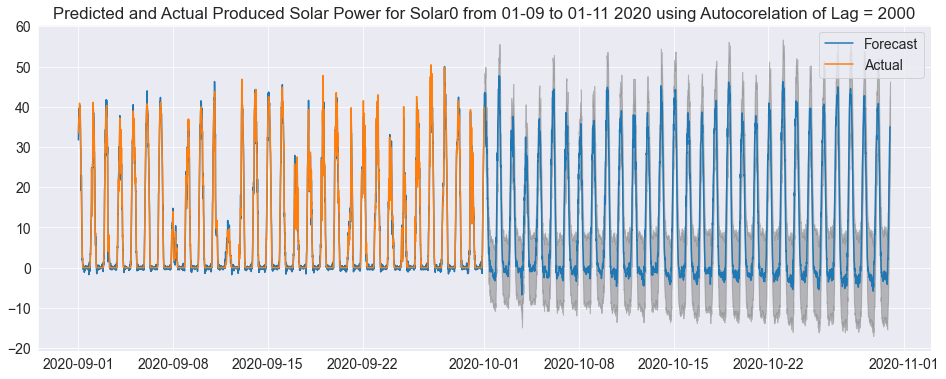

In [231]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Solar0"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Produced Solar Power for Solar0 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Solar1

In [265]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [266]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Solar1"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Solar1"])-1, 0, -1):
    if str(demand_df.at[i, "Solar1"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2018-12-31 13:00:00 87422
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


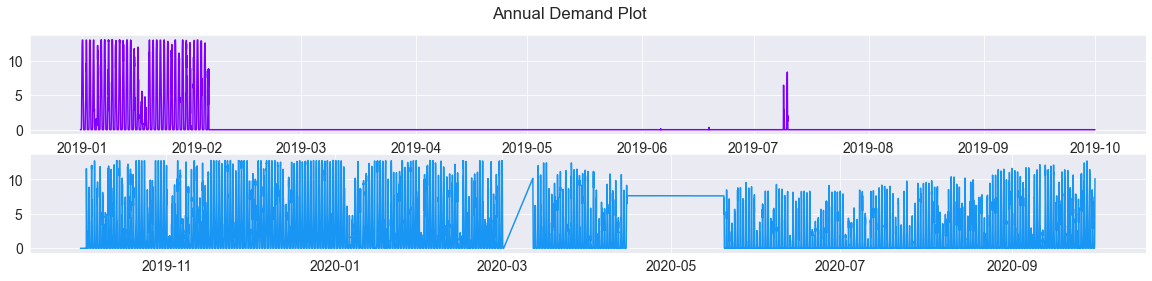

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019','2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Solar1'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Solar1'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Solar1'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Solar1'] = fill_missing(building_df)
demand_df.head()

In [268]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Solar1'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Solar1'][i]

# save smoothed demand_df
demand_df['Solar1'] = smooth_like_butter(peaks, demand_df['Solar1'])
demand_df.to_csv("demand_smoothed_solar1")

In [269]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     70176 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [270]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Solar1"][87422:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.205287760553055
p-value: 6.42063952253055e-30


In [271]:
mod = AutoReg(demand_df["Solar1"][87422:148809].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


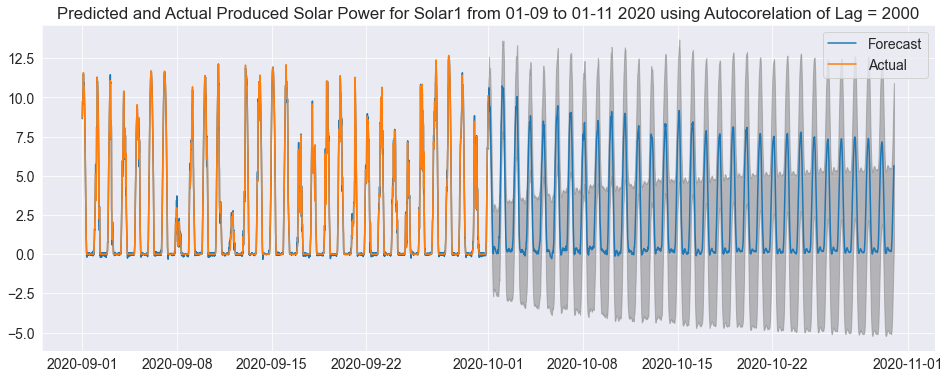

In [272]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Solar1"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Produced Solar Power for Solar1 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Solar2

In [253]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [254]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Solar2"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Solar2"])-1, 0, -1):
    if str(demand_df.at[i, "Solar2"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-06-05 14:00:00 102402
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


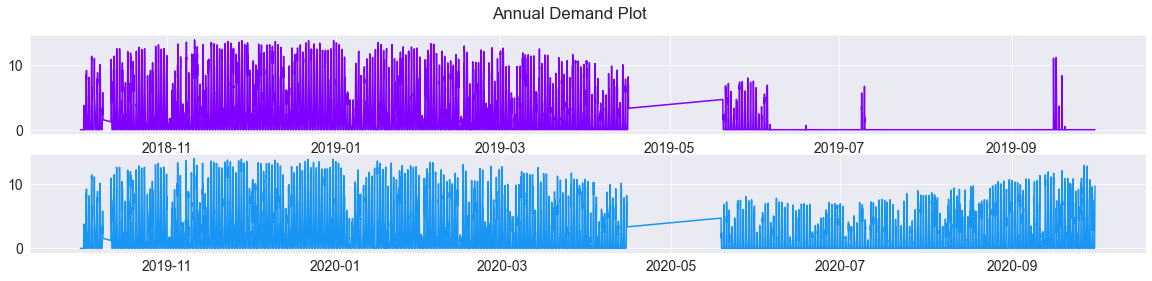

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019','2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Solar2'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Solar2'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Solar2'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Solar2'] = fill_missing(building_df)
demand_df.head()

In [262]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Solar2'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Solar2'][i]

# save smoothed demand_df
demand_df['Solar2'] = smooth_like_butter(peaks, demand_df['Solar2'])
demand_df.to_csv("demand_smoothed_solar2")

In [263]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     70176 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [273]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Solar2"][102402:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -26.090426987857644
p-value: 0.0


In [274]:
mod = AutoReg(demand_df["Solar2"][102402:148809].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


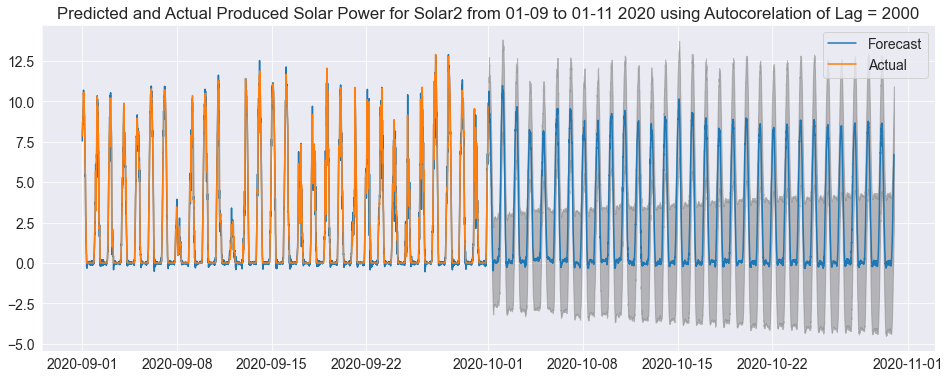

In [275]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Solar2"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Produced Solar Power for Solar2 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Solar3

In [276]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [277]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Solar3"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Solar3"])-1, 0, -1):
    if str(demand_df.at[i, "Solar3"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-06-05 14:00:00 102402
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


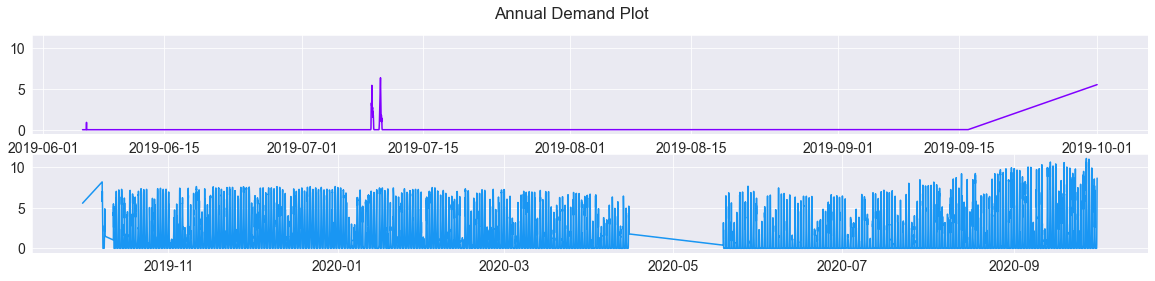

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019','2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Solar3'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Solar3'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Solar3'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Solar3'] = fill_missing(building_df)
demand_df.head()

In [279]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Solar3'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Solar3'][i]

# save smoothed demand_df
demand_df['Solar3'] = smooth_like_butter(peaks, demand_df['Solar3'])
demand_df.to_csv("demand_smoothed_solar3")

In [280]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     70176 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [281]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Solar3"][102402:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -23.813112407992037
p-value: 0.0


In [282]:
mod = AutoReg(demand_df["Solar3"][102402:148809].ffill(), 2000, old_names=False)
res = mod.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


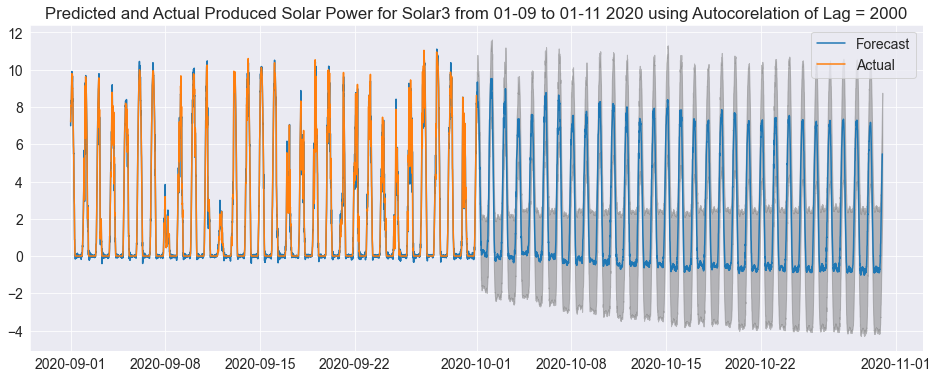

In [283]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Solar3"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Produced Solar Power for Solar3 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Solar4

In [298]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [299]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Solar4"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Solar4"])-1, 0, -1):
    if str(demand_df.at[i, "Solar4"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-06-05 14:00:00 102402
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


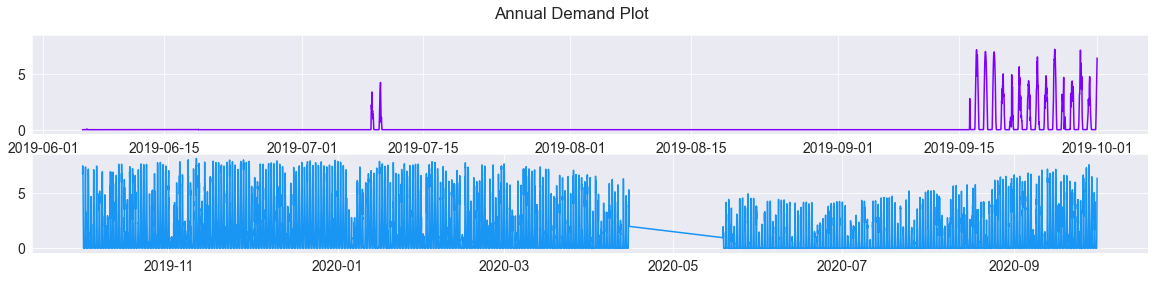

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019','2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Solar4'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Solar4'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Solar4'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Solar4'] = fill_missing(building_df)
demand_df.head()

In [301]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Solar4'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Solar4'][i]

# save smoothed demand_df
demand_df['Solar4'] = smooth_like_butter(peaks, demand_df['Solar4'])
demand_df.to_csv("demand_smoothed_solar4")

In [302]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     70176 non-null   float64
 11  Solar5     59948 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [303]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Solar4"][102402:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -28.56792334016471
p-value: 0.0


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


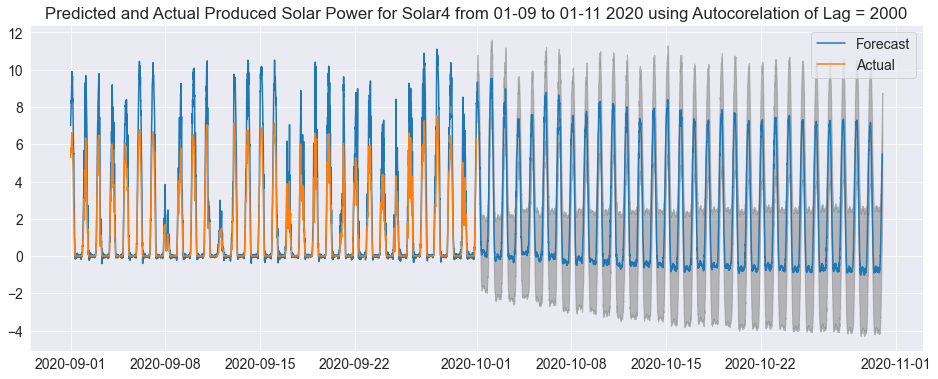

In [304]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Solar4"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Produced Solar Power for Solar4 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()

# Reproducing for Solar5

In [291]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [292]:
# Find the first none-Nan value of Building 1 to findd the starting date
for i in demand_df.index:
    if str(demand_df.at[i, "Solar5"]) != "nan":
        print("First:", demand_df.at[i, "Date"], str(i))
        break
        
# Find the last  none-Nan value of Building 1 to find the starting date
for i in range(len(demand_df["Solar5"])-1, 0, -1):
    if str(demand_df.at[i, "Solar5"]) != "nan":
        print("Last:", demand_df.at[i, "Date"], str(i))
        break

First: 2019-01-15 13:00:00 88862
Last: 2020-09-30 23:45:00 148809


number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35136


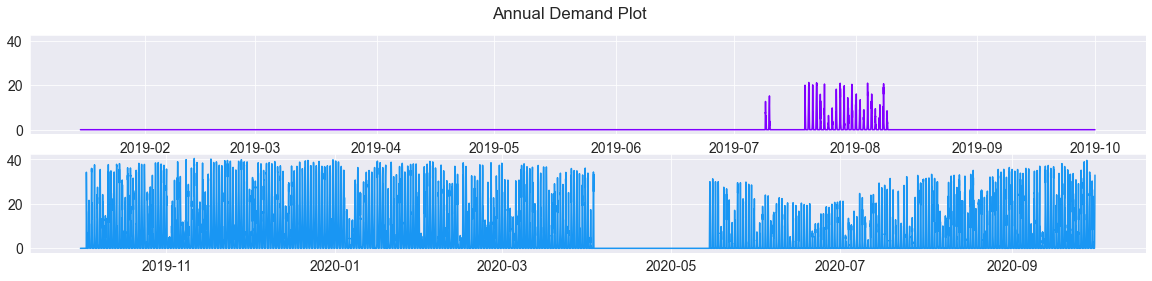

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
#create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2018','2019','2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Solar5'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Solar5'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Solar5'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2018-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Solar5'] = fill_missing(building_df)
demand_df.head()

In [294]:
# Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Solar5'], height=700)
Building1_peaks = np.zeros(len(demand_df))
Building1_peaks[:] = np.NaN
for i in peaks:
    Building1_peaks[i] = demand_df['Solar5'][i]

# save smoothed demand_df
demand_df['Solar5'] = smooth_like_butter(peaks, demand_df['Solar5'])
demand_df.to_csv("demand_smoothed_solar5")

In [295]:
# Set date values as index
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df.set_index('Date', inplace=True)
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148810 entries, 2016-07-03 21:30:00 to 2020-09-30 23:45:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Building0  101406 non-null  float64
 1   Building1  60395 non-null   float64
 2   Building3  148251 non-null  float64
 3   Building4  26096 non-null   float64
 4   Building5  11580 non-null   float64
 5   Building6  39402 non-null   float64
 6   Solar0     15208 non-null   float64
 7   Solar1     61388 non-null   float64
 8   Solar2     46408 non-null   float64
 9   Solar3     46408 non-null   float64
 10  Solar4     46408 non-null   float64
 11  Solar5     70176 non-null   float64
dtypes: float64(12)
memory usage: 14.8 MB


In [296]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(demand_df["Solar5"][88862:148809].ffill())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -24.079097829241828
p-value: 0.0


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


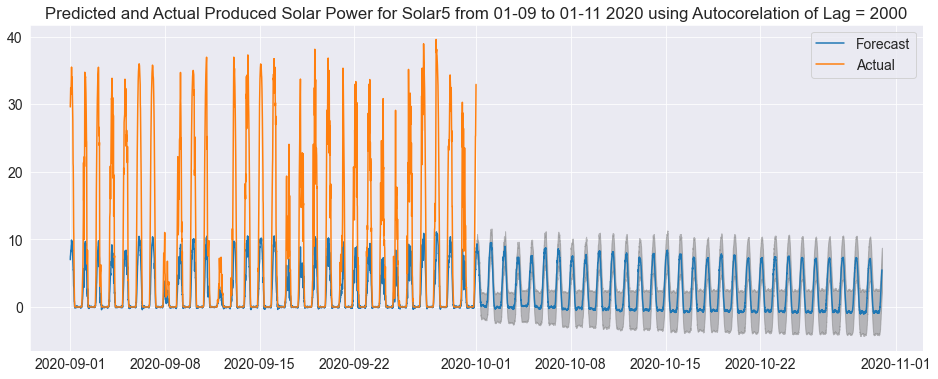

In [297]:
#fig = res.plot_predict(148809, 151785)

#demand_df.index = pd.DatetimeIndex(start="2020-09-01 00:00:00", end="2020-09-30 23:45:00", freq="15min")

fig = res.plot_predict(start="2020-09-01 00:00:00", end="2020-10-30 23:45:00")

#plt.plot(demand_df["Building0"][148809 - 2880: 148809])
plt.plot(demand_df["Solar5"]["2020-09-01 00:00:00": "2020-09-30 23:45:00"])
plt.legend(["Forecast", "Actual"])
plt.title("Predicted and Actual Produced Solar Power for Solar5 from 01-09 to 01-11 2020 using Autocorelation of Lag = 2000")
plt.show()